<a href="https://www.kaggle.com/code/nishantpatel54/30day-stock-forecast-lstm?scriptVersionId=145288988" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 928.0/928.0 kB 16.8 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for peewee: filename=peewee-3.16.3-cp310-cp310-linux_x86_64.whl size=314460 sha256=bc8b50d8fd43f4b44633daa559e7d62926f8287fd36c38fe3ff6ca91d8120251
  Stored in directory: /root/.cache/pip/wheels/c8/ac/6d/ad6d828725ffbe3abc508c95d25dd0c5fcc63539ae47913790
Successfully built peewee


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout,LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
ticker = 'MSFT'
dataset = yf.download(ticker, period='5y')
#dataset.drop(dataset.tail(120).index, inplace=True)
train_set = dataset[['Close']].fillna(method='ffill')
train_set = train_set.values.reshape(-1,1)
dataset.shape, train_set.shape

[*********************100%%**********************]  1 of 1 completed


((1257, 6), (1257, 1))

In [3]:
sc = MinMaxScaler(feature_range=(0,1))
sc = sc.fit(train_set)
train_set_scaled = sc.transform(train_set)
train_set_scaled[:10]

array([[0.06783238],
       [0.06300875],
       [0.0683223 ],
       [0.04533467],
       [0.04439255],
       [0.05818512],
       [0.05076124],
       [0.06357402],
       [0.06248117],
       [0.05415286]])

In [4]:
X=[]
y=[]
lookback = 90
forecast = 30
for i in range(lookback, len(train_set_scaled) - forecast + 1):
    X.append(train_set_scaled[i - lookback : i])
    y.append(train_set_scaled[i : i + forecast])
   
X=np.array(X)
y=np.array(y)
X_train, X_val , y_train, y_val = train_test_split(X, y, test_size=0.33)


In [5]:
#model

model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(lookback, 1)))
model.add(Dropout(rate=0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(LSTM(units=100))
model.add(Dropout(rate=0.2))
model.add(Dense(forecast))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 90, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 90, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 90, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 90, 100)           80400     
                                                                 
 dropout_2 (Dropout)         (None, 90, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 90, 100)           8

In [6]:
#train

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, validation_data=(X_val,y_val), batch_size=32)

Epoch 1/100
24/24 [==============================] - 21s 504ms/step - loss: 0.0843 - val_loss: 0.0098
Epoch 2/100
24/24 [==============================] - 10s 411ms/step - loss: 0.0207 - val_loss: 0.0047
Epoch 3/100
24/24 [==============================] - 10s 412ms/step - loss: 0.0172 - val_loss: 0.0069
Epoch 4/100
24/24 [==============================] - 10s 411ms/step - loss: 0.0145 - val_loss: 0.0045
Epoch 5/100
24/24 [==============================] - 10s 423ms/step - loss: 0.0127 - val_loss: 0.0044
Epoch 6/100
24/24 [==============================] - 10s 405ms/step - loss: 0.0111 - val_loss: 0.0058
Epoch 7/100
24/24 [==============================] - 10s 409ms/step - loss: 0.0112 - val_loss: 0.0046
Epoch 8/100
24/24 [==============================] - 10s 420ms/step - loss: 0.0098 - val_loss: 0.0059
Epoch 9/100
24/24 [==============================] - 10s 404ms/step - loss: 0.0103 - val_loss: 0.0042
Epoch 10/100
24/24 [==============================] - 10s 410ms/step - loss: 0.009

In [7]:
X_ = train_set_scaled[-lookback:]
X_ = X_.reshape(1, lookback, 1)

y_ = model.predict(X_).reshape(-1,1)
y_ = sc.inverse_transform(y_)

dataset_past = dataset[['Close']].reset_index()
dataset_past.rename(columns={'index':'Date','Close':'Actual'},inplace=True)
dataset_past['Date'] = pd.to_datetime(dataset_past['Date'])
dataset_past['Forecast'] = np.nan
dataset_past['Forecast'].iloc[-1] = dataset_past['Actual'].iloc[-1]

dataset_future = pd.DataFrame(columns=['Date','Actual','Forecast'])
dataset_future['Date'] = pd.date_range(start=dataset_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods = forecast)
dataset_future['Actual'] = np.nan
dataset_future['Forecast'] = y_.flatten()
dataset_past, dataset_future

actual_preds = pd.concat([dataset_past, dataset_future], ignore_index=True)
actual_preds=actual_preds.set_index('Date')
actual_preds

1/1 [==============================] - 2s 2s/step


/tmp/ipykernel_20/1629040079.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_past['Forecast'].iloc[-1] = dataset_past['Actual'].iloc[-1]


,Actual,Forecast
Date,,
2018-10-05,112.129997,NaN
2018-10-08,110.849998,NaN
2018-10-09,112.260002,NaN
2018-10-10,106.160004,NaN
2018-10-11,105.910004,NaN
...,...,...
2023-10-30,NaN,325.220520
2023-10-31,NaN,322.159912
2023-11-01,NaN,320.169189


                Actual    Forecast
Date                              
2018-10-05  112.129997         NaN
2018-10-08  110.849998         NaN
2018-10-09  112.260002         NaN
2018-10-10  106.160004         NaN
2018-10-11  105.910004         NaN
...                ...         ...
2023-09-28  313.640015         NaN
2023-09-29  315.750000         NaN
2023-10-02  321.799988         NaN
2023-10-03  313.390015         NaN
2023-10-04  318.959991  318.959991

[1257 rows x 2 columns]
              Forecast
Date                  
2023-10-05  323.169769
2023-10-06  321.894257
2023-10-07  323.370575
2023-10-08  322.184570
2023-10-09  323.259766
2023-10-10  324.428101
2023-10-11  322.869629
2023-10-12  325.843567
2023-10-13  325.160736
2023-10-14  323.664337
2023-10-15  323.038055
2023-10-16  323.310516
2023-10-17  322.737427
2023-10-18  325.143341
2023-10-19  324.988617
2023-10-20  324.810455
2023-10-21  322.690247
2023-10-22  321.160034
2023-10-23  325.342072
2023-10-24  322.966736
2023-10-25  32

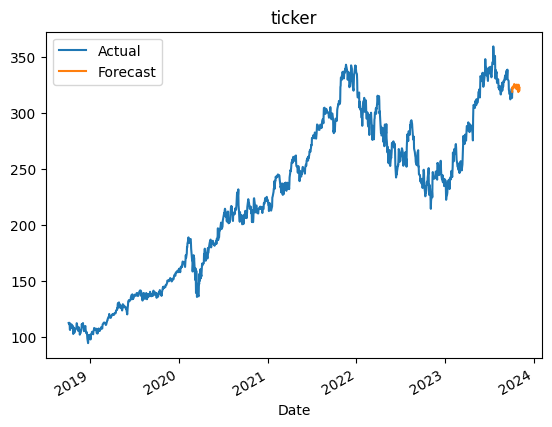

In [8]:
actual_preds.plot(title='ticker')
print(actual_preds[:-forecast])
print(actual_preds[-forecast:].drop('Actual',axis='columns'))

In [9]:
# dataset_future_actual = dataset[['Close']][-30:].reset_index()
# dataset_future_actual.rename(columns={'index':'Date','Close':'30day History'},inplace=True)
# dataset_future_actual['Date'] = pd.to_datetime(dataset_future_actual['Date'])
# dataset_future_actual['Forecast'] = np.nan
# dataset_future_actual = dataset_future_actual.set_index('Date')
# dataset_future_actual = dataset_future_actual.drop('Forecast',axis='columns')
# dataset_future_actual['Forecast'] = y_.flatten()
# dataset_future_actual.plot(title='AAPL actual 30 day history')